Import the libraries

In [1]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

Load the dataset

In [150]:
img_dir = 'img_align_celeba'
attr_file = 'list_attr_celeba.csv'
output_dir = 'data'

df_attr = pd.read_csv(attr_file)
df_attr.set_index('image_id', inplace=True)

Initialize the dataset

In [151]:
classifier = Sequential()

Pre-processing the data

In [152]:
# Select only the "Bald" attribute
df_bald = df_attr[['Bald']]

# Map 1 → 'Bald', -1 → 'Not_Bald'
df_bald['label'] = df_bald['Bald'].apply(lambda x: 'Bald' if x == 1 else 'Not_Bald')

# Split into training (80%) and testing (20%) using stratification
train_df, test_df = train_test_split(df_bald, test_size=0.2, random_state=42, stratify=df_bald['label'])

# Function to copy images to their respective folders
def copy_images(df, split):
    for label in ['Bald', 'Not_Bald']:
        folder = os.path.join(output_dir, split, label)
        os.makedirs(folder, exist_ok=True)  # Create the folder if it doesn't exist
        df_split = df[df['label'] == label]
        for img_name in df_split.index:
            src = os.path.join(img_dir, img_name)
            dst = os.path.join(folder, img_name)
            shutil.copy(src, dst)

# Copy images to train and test directories
copy_images(train_df, 'train')
copy_images(test_df, 'test')

# Define paths to train and test directories
train_dir = 'data/train'
test_dir = 'data/test'

# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',  # Binary classification: Bald or Not_Bald
    batch_size=32,
    image_size=(64, 64),  # Resize all images to 64x64
    shuffle=True
)

# Load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(64, 64),
    shuffle=False
)

# Print class names and indices
class_names = train_dataset.class_names
print("Class names:", class_names)
class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
print("Class indices:", class_indices)

# Normalize pixel values to range [0, 1]
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Apply data augmentation only to training set
data_augmentation = tf.keras.Sequential([
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.1, 0.1)
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

C:\Users\Zayd\AppData\Local\Temp\ipykernel_22960\2122673159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bald['label'] = df_bald['Bald'].apply(lambda x: 'Bald' if x == 1 else 'Not_Bald')


Found 162079 files belonging to 2 classes.
Found 40520 files belonging to 2 classes.
Class names: ['Bald', 'Not_Bald']
Class indices: {'Bald': 0, 'Not_Bald': 1}


Convolution layer 1

In [153]:
classifier.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))

C:\Users\Zayd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Pooling

In [154]:
classifier.add(MaxPooling2D(pool_size=(2,2)))

Second convolution layer + pooling

In [155]:
classifier.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

Flatten layer

In [156]:
classifier.add(Flatten())

Output

In [157]:
classifier.add(Dense(units=128, activation='relu'))
classifier.add(layers.Dropout(0.5))
classifier.add(Dense(units=1, activation='sigmoid'))

CNN summary

In [158]:
classifier.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,217 (3.10 MB)

 Trainable params: 813,217 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

CNN compilation

In [159]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN fitting

In [ ]:
classifier.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
  43/5065 ━━━━━━━━━━━━━━━━━━━━ 2:37 31ms/step - accuracy: 0.9500 - loss: 0.2240

CNN save

In [139]:
classifier.save('bald_classifier_model.keras')

Evaluate accuracy

In [140]:
loss, accuracy = classifier.evaluate(test_dataset)
print("Test Accuracy:", accuracy)

Found 40520 images belonging to 2 classes.
   4/1267 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.0247 - loss: 3.8371 

C:\Users\Zayd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.8960 - loss: 0.4320
Test Accuracy: 0.9782083034515381


Confusion matrix

In [141]:
# Get predictions and true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = classifier.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Bald', 'Bald'], yticklabels=['Not Bald', 'Bald'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

KeyboardInterrupt: 

Testing the model on a single prediction using an image from outside the dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction for the image: Bald


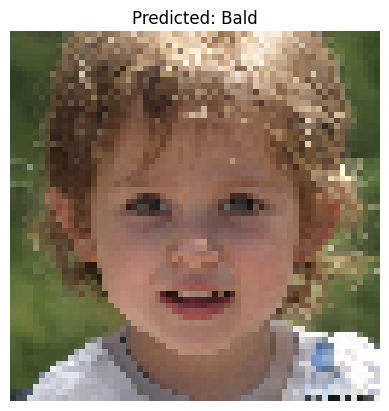

In [142]:
# Load your trained model
classifier = load_model('bald_classifier_model.keras')

# Load and preprocess the image using your method
test_image = image.load_img('test.jpg',
                            target_size=(64, 64))
test_image_array = image.img_to_array(test_image).astype('float32') / 255
test_image_array = np.expand_dims(test_image_array, axis=0)  # Add batch dimension

# Predict
prediction = classifier.predict(test_image_array)
predicted_class = 'Bald' if prediction[0][0] > 0.5 else 'Not Bald'

# Show result
print("Prediction for the image:", predicted_class)

# Display the image with predicted label
plt.imshow(test_image_array[0])
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

Prediction of some the test set images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


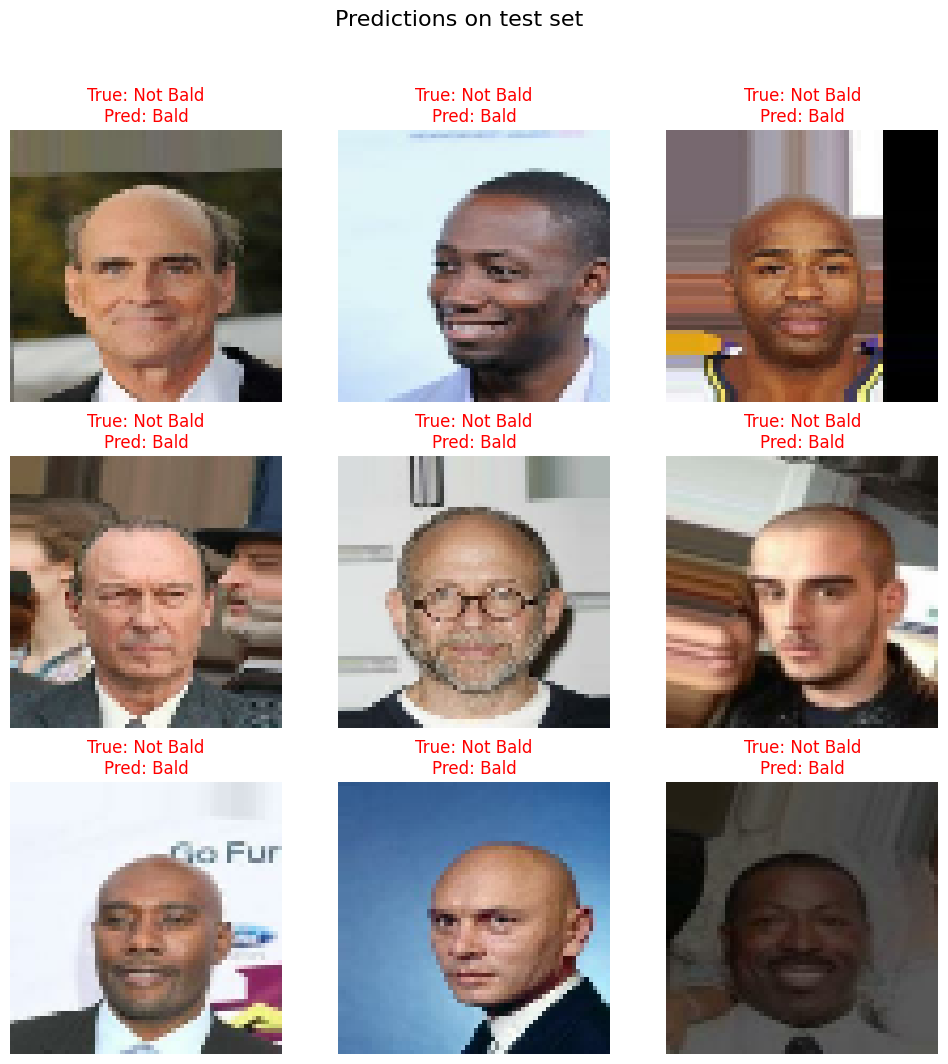

In [143]:
# Get a batch of images from the test set
for images, labels in test_dataset.take(1):
    predictions = classifier.predict(images)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Plot the first 9 images with predicted and true labels
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        true_label = 'Bald' if labels[i].numpy() == 1 else 'Not Bald'
        predicted_label = 'Bald' if predicted_labels[i] == 1 else 'Not Bald'
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")
    plt.suptitle("Predictions on test set", fontsize=16)
    plt.show()

Live camera

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Use the pre-trained Keras model named 'classifier'
model = classifier

# Start capturing video from the default webcam (index 0)
cap = cv2.VideoCapture(0)

while True:
    # Capture a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Unable to read from webcam.")
        break

    # Resize the frame to match the model's expected input size
    resized_frame = cv2.resize(frame, (64, 64))

    # Normalize the pixel values and expand dimensions to match input shape
    input_data = resized_frame / 255.0
    input_data = np.expand_dims(input_data, axis=0)  # Shape becomes (1, 64, 64, 3)

    # Perform prediction using the model
    prediction = model.predict(input_data)

    # Convert prediction to label based on threshold (binary classification)
    predicted_label = "Bald" if prediction[0][0] > 0.5 else "Not Bald"

    # Overlay the prediction text on the original frame
    cv2.putText(
        frame,
        f"Prediction: {predicted_label}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),  # Green text
        2
    )

    # Show the annotated frame
    cv2.imshow("Webcam", frame)

    # Exit loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close any OpenCV windows
cap.release()
cv2.destroyAllWindows()
